# Bulk deconvolution

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: deconvolution-bulk-deconvolution-key-takeaway-1
:link-type: ref
Use unbiased reference data with no missing cell type.
:::

:::{card}
:link: deconvolution-bulk-deconvolution-key-takeaway-2
:link-type: ref
Normalize the reference data using library size normalization.
:::

:::{card}
:link: deconvolution-bulk-deconvolution-key-takeaway-3
:link-type: ref
Feature selection prior deconvolution improves the accuracy of the results particularly for linear deconvolution methods. 
:::

:::{card}
:link: deconvolution-bulk-deconvolution-key-takeaway-4
:link-type: ref
Deconvolution is a challenging task (see limitations and traps). Therefore, we recommend the users to try more than one deconvolution method and select one after assessing the results biologically.
:::

```

``````{dropdown} <i class="fa-solid fa-gear"></i>&nbsp;&nbsp;&nbsp;Environment setup
`````{tab-set}
   
````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} differential_gene_expression.yml
:language: yaml
```
````

`````
``````

_TL;DR We provide a brief overview over basic concepts of cell type deconvolution including input structure, data preprocessing and analysis of the output data._

(deconvolution-bulk-deconvolution-key-takeaway-1)=
## Background

Studying differences in cell type compositions within a bulk tissue is important for several reasons. First, interactions between cell types play a major role in disease progression and recovery. Second, molecular patterns (such as gene expression and protein abundance) are often directly associated with the cell types compositions within the tissue. Understanding these compositions is crucial for studying the underlying molecular mechanisms of a biological condition such as disease. Third, uncovering disease-specific cell type patterns allow for better therapeutic targeting, providing an important clinical utility.

Cell type deconvolution is a computational framework designed for inferring the compositions of cell populations within a bulk heterogeneous tissue {cite}`Kuhn2012,Schwartz2010,Du2019,Zaitsev2019`. As measuring these compositions experimentally is time-consuming and expensive, deconvolution methods allow large scale analysis of cell populations based on molecular data. Deconvolution methods usually follow linear regression defined as: 

$y = bX$ 

where, $y$ refers to a mixture of heterogeneous gene expression profile using common molecular pipelines (e.g. microarray or RNA-seq), $X$ is a signature matrix containing homogeneous cell type-specific profiles, and $b$ is the vector of cellular proportions in the mixture data inferred by the deconvolution method {cite}`Baron2016`. To select an optimal deconvolution method suitable for the targeted biological conditions, the impact of several technical and biological factors should be considered including: the deconvolution method, reference data with missing or rare cell types, data normalization and the selection of features (markers).

The signature matrix $X$, used to infer cellular compositions, reflects our best knowledge of cellular heterogeneity within the tissue and highly influences the success of the deconvolution process {cite}`Aliee2021`. Originally, signature matrices were generated by profiling sorting cells from a heterogeneous tissue (using FACS or CyTOF), suffering from internal biases due to the pre-selection of cell type panels and the absence of appropriate antibodies {cite}`Monaco2019,Aran2017`. Today, these matrices are mainly generated as unbiased profiles using single cell technologies, allowing the generation of signature matrices across different organisms, tissues and biological conditions {cite}`Aliee2021,Newman2019`.

## Approaches

Bulk deconvolution approaches can be divided into linear regression based methods, enrichment based methods, non-linear deep-learning based methods and others.

The most common type of cell type deconvolution methods are linear regression-based. These methods try to directly solve the $y = bX$ equation using different regularizations and relying on a relatively high number of features. Examples of such tools are **CIBERSORTx** {cite}`Newman2019`, **MuSiC** {cite}`WangXuran2019`, **dtangle** {cite}`Hunt2018` and **DWLS** {cite}`Tsoucas2019`.

Enrichment based tools on the other hand calculate an enrichment score for each cell type separately, based on a gene set that represents this cell type. The enrichment scores for all cell types are then combined and transformed to compositions by a method-specific transformation function. As these methods only consider a single cell type at a time, tend to provide meaningful insights in simple cases, but are less accurate when reference data includes many cell types. **xCell** {cite}`Aran2017` is an example of an enrichment based tool.

The third option pose non-linear deep learning methods that emerged with the promise of improving deconvolution accuracy, while still attempting to maintain high biological interpretability. It is still early to say whether these methods can be better than other types of methods. **Scaden** {cite}`Menden2020` is an example of such a deep-learning based method.

Bulk deconvolution methods have been benchmarked extensively and the results are overall quite consistent {cite}`ShenOrr2013,Cobos2020,Jin2021,Nadel2021`. Methods using single-cell RNA-seq data show good performance whereas semi-supervised approaches show higher error rates. Failing to include cell types in the reference that are present in the bulk mixture lead to worse results in any case {cite}`Cobos2020`. Cobos et al. recommend that (1) the input data should be in linear scale, (2) Avoid row scaling, column min-max, column z-score or quantile normalization, (3) regression bulk deconvolution methods like CIBERSORTx or FARDEEP {cite}`Hao2019` perform well and if scRNA-seq data is available DWLS, MuSiC or SCDC {cite}`Dong2020` should also be applied for result comparisons, (4) a stringent marker selection strategy that focuses on the differences between the first and second cell types with highest expression values should be used, (5) a comprehensive reference matrix that includes all relevant cell types that are present in the mixture should be used {cite}`Cobos2020`.
The effect of the normalization strategy is unclear with Li et al. {cite}`Li2016` suggesting that it has a strong effect on the results which was not confirmed by Cobos et al. {cite}`Cobos2020`.

Since many bulk deconvolution tools, including the well-performing CIBERSORTx, are only available as web tools, we opt to demonstrate a use-case with MuSic.

It is important to note that MuSiC requires multiple single-cell samples including the same cell types. In practice, our reference profile might not include more than a single sample or some cell types might be missing across the samples. In these cases, MuSiC fails and another deconvolution method should be selected. 

## Deconvolving bulk COVID-19 whole blood samples

In the following use-case we deconvolve 49 bulk whole blood RNA-seq samples collected from 39 COVID-19 patients and 10 healthy controls {cite}`Aschenbrenner2020` using MuSiC. As single-cell reference dataset we'll use whole blood single-cell RNA-seq data of patients with COVID-19 {cite}`Schulte-Schrepping2020`.

### Environment setup

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sci

### Loading Data

We start by reading the single-cell and bulk data. We do not scale the data as it has been shown that deconvolution methods using scRNA-seq data as reference, perform best when applied to data in linear scale with improved accuracy after library size normalization {cite}`Jin2021,Cobos2020`. 

In [45]:
data_file = "/storage/groups/ml01/workspace/amit.frishberg/OriginalData/"
adata = sc.read(data_file + "seurat_COVID19_freshWB_PBMC_cohort2_incl_raw.h5ad")

adata.X = adata.layers["counts"]
adata = adata[adata.obs["cells"] == "Whole_blood"].copy()
adata

AnnData object with n_obs × n_vars = 89883 × 33417
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'percent.mito', 'percent.hb', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'demultID', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'date_of_sampling', 'experiment', 'cartridge', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'diagnosis', 'oxygen', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'primary_complaint', 'RNA_snn_res.0.8', 'cluster_labels_res.0.8', 'new.order', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [46]:
adata.obs["cluster_labels_res.0.8"].value_counts()

Neutrophils_1             22714
Neutrophils_2             18675
Neutrophils_3              9986
CD4_T_cells_1              6278
CD14_Monocytes_1           5362
Neutrophils_4              4710
CD8_T_cells                3255
Megakaryocytes             3180
NK_cells                   2916
B_cells_1                  2561
CD4_T_cells_2              1917
Mixed_cells                1727
Immature Neutrophils_1     1317
CD16_Monocytes              983
Immature Neutrophils_2      981
CD14_Monocytes_3            632
Eosinophils                 579
CD14_Monocytes_2            556
CD4_T_cells_3               409
Plasmablast                 390
Prol. cells                 247
mDC                         235
B_cells_2                   138
pDC                          86
CD34+ GATA2+ cells           49
Name: cluster_labels_res.0.8, dtype: int64

In [4]:
bulk = pd.read_csv(data_file + "BulkSmall.txt", sep="\t", index_col=0)
metadata = pd.read_csv(data_file + "annoSmall.txt", sep="\t", index_col=0)
metadata.index = metadata.index.astype("str")
metadata = metadata.loc[bulk.transpose().index]

### Data preprocessing

After reading the data, we need to remove *undefined* cells from our single-cell reference data. Here, we remove mixed and proliferating cells which are not limited to a single cell type. 

**Note** Quality control by means of removing low quality cells and genes has already been perform on the single-cell data. So, we skip that.

In [50]:
adata = adata[
    ~adata.obs["cluster_labels_res.0.8"].isin(["None", "Mixed_cells", "Prol. cells"])
].copy()
ct_counts = adata.obs["cluster_labels_res.0.8"].value_counts()
adata.obs["cluster_labels_res.0.8"].value_counts()

Neutrophils_1             22714
Neutrophils_2             18675
Neutrophils_3              9986
CD4_T_cells_1              6278
CD14_Monocytes_1           5362
Neutrophils_4              4710
CD8_T_cells                3255
Megakaryocytes             3180
NK_cells                   2916
B_cells_1                  2561
CD4_T_cells_2              1917
Immature Neutrophils_1     1317
CD16_Monocytes              983
Immature Neutrophils_2      981
CD14_Monocytes_3            632
Eosinophils                 579
CD14_Monocytes_2            556
CD4_T_cells_3               409
Plasmablast                 390
mDC                         235
B_cells_2                   138
pDC                          86
CD34+ GATA2+ cells           49
Name: cluster_labels_res.0.8, dtype: int64

It has been shown that deconvolution methods commonly fail to predict the proportion of rare cells {cite}`Tsoucas2019`. In case that you want to remove rare cell types, you can limiting cell types to be above `cellTypeNumCutOff` cells. This cutoff is user-defined and should be selected based on the data.

In [59]:
# removing very rare cells
rare_ct_cut_off = 50  # This is a user-specific parameter based on the data
ct_to_keep = ct_counts[ct_counts > rare_ct_cut_off].index
adata = adata[adata.obs["cluster_labels_res.0.8"].isin(ct_to_keep)].copy()
adata.obs["cluster_labels_res.0.8"].value_counts()

Neutrophils_1             22714
Neutrophils_2             18675
Neutrophils_3              9986
CD4_T_cells_1              6278
CD14_Monocytes_1           5362
Neutrophils_4              4710
CD8_T_cells                3255
Megakaryocytes             3180
NK_cells                   2916
B_cells_1                  2561
CD4_T_cells_2              1917
Immature Neutrophils_1     1317
CD16_Monocytes              983
Immature Neutrophils_2      981
CD14_Monocytes_3            632
Eosinophils                 579
CD14_Monocytes_2            556
CD4_T_cells_3               409
Plasmablast                 390
mDC                         235
B_cells_2                   138
pDC                          86
Name: cluster_labels_res.0.8, dtype: int64

We need to filter for the shared genes across bulk and single-cell data before selecting highly variable genes.

In [48]:
bulk_sc_genes = np.intersect1d(bulk.index, adata.var_names)
bulk = bulk.loc[bulk_sc_genes, :].copy()
adata = adata[:, bulk_sc_genes].copy()

(deconvolution-bulk-deconvolution-key-takeaway-2)=
### Visualization of single-cell data

For visualization of single-cell data, we first normalize the counts, select highly-variable genes and log transform the data.

In [7]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=False)
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=5000)
adata_log = sc.pp.log1p(
    adata, copy=True
)  # logged counts are only used for visualisation (can also work with layers)

We then reduce the dimensionality using PCA and visualize the data using UMAP:

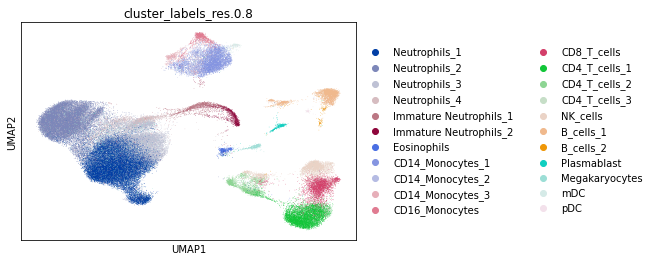

In [10]:
sc.tl.pca(adata_log)
adata_log.obsm["X_pca"] *= -1  # multiply by -1 to match Seurat
sc.pp.neighbors(adata_log, n_neighbors=30)
sc.tl.umap(adata_log)
sc.pl.umap(adata_log, color="cluster_labels_res.0.8")

### Deconvolving using MuSiC

#### Loading R

In [8]:
# R interface
import anndata2ri
from rpy2.robjects import pandas2ri

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

C:\Users\Shennor\.conda\envs\eharpy\lib\site-packages\rpy2\robjects\packages.py:365: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


To use the R scripts, we need to convert the data from Python to R. In some cases, this requires sub-sampling of the data to avoid memory limitations.

In [51]:
import itertools
import random

downSamplingSize = 80
downSamplingIndexes = [
    random.sample(
        np.where(currCell == adata.obs["cluster_labels_res.0.8"])[0].tolist(),
        np.min(
            [downSamplingSize, np.sum(currCell == adata.obs["cluster_labels_res.0.8"])]
        ),
    )
    for currCell in np.unique(adata.obs["cluster_labels_res.0.8"])
]
downSamplingIndexes = list(itertools.chain(*downSamplingIndexes))

adata_r = adata[downSamplingIndexes].copy()
adata_r

AnnData object with n_obs × n_vars = 1809 × 26807
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'percent.mito', 'percent.hb', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'demultID', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'date_of_sampling', 'experiment', 'cartridge', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'diagnosis', 'oxygen', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'primary_complaint', 'RNA_snn_res.0.8', 'cluster_labels_res.0.8', 'new.order', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

If sub-sampling is not required (data is relatively small), one can simply convert the entire AnnData to an R object

In [21]:
adata_r = adata.copy()
adata_r

AnnData object with n_obs × n_vars = 87860 × 26807
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'percent.mito', 'percent.hb', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'demultID', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'date_of_sampling', 'experiment', 'cartridge', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'diagnosis', 'oxygen', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'primary_complaint', 'RNA_snn_res.0.8', 'cluster_labels_res.0.8', 'new.order', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'n_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'

#### Running MuSiC

In [24]:
%%R
library(MuSiC)
library(Biobase)

We will first gather all the remaining inputs needed for running MuSiC:
    <br>1. adata_r - contains the single cell matrix which will used as a reference.
    <br>2. cell_subsets_r - cell type identities.
    <br>3. bulk - the bulk samples which the deconvolution process will be conducted on.
    <br>4. sc_genes - gene markers used in the MuSiC analysis.

In [52]:
cell_subsets_r = adata_r.obs["cluster_labels_res.0.8"].astype(str).copy()
sc_genes = adata_r.var_names

MuSiC runs the deconvolution framework one sample at a time. Here, 9*** are sample names.

In [53]:
%%R -i adata_r,cell_subsets_r,bulk,sc_genes -o musicRes
df = data.frame(cellNames = cell_subsets_r, Sample = factor(rep(1, dim(adata_r@colData)[1])))
row.names(df) = row.names(adata_r@colData)
df = new("AnnotatedDataFrame", data = df) # Cell type identities are stored as an AnnotatedDataFrame

# Creating an ExpressionSet from the single cell matrix
scDataMatrix = Matrix::as.matrix(adata_r@assays@data@listData[[1]])
row.names(scDataMatrix) = sc_genes
scDataMatrix = scDataMatrix[rowSums(scDataMatrix)>0,] # Removing genes with no reads
SCDataES <- Biobase::ExpressionSet(assayData=scDataMatrix,phenoData = df, protocolData = df)

bulkDataES <- Biobase::ExpressionSet(assayData=as.matrix(bulk)) # Creating an ExpressionSet from the bulk matrix
musicRes = MuSiC::music_prop(bulk.eset = bulkDataES, sc.eset = SCDataES, clusters = 'cellNames') # Running MuSiC

R[write to console]: Creating Relative Abundance Matrix...

R[write to console]: Creating Variance Matrix...

R[write to console]: Creating Library Size Matrix...

R[write to console]: Used 20407 common genes...

R[write to console]: Used 23 cell types in deconvolution...

R[write to console]: 9088 has common genes 18250 ...

R[write to console]: 9089 has common genes 17774 ...

R[write to console]: 9091 has common genes 18598 ...

R[write to console]: 9092 has common genes 16184 ...

R[write to console]: 9093 has common genes 18585 ...

R[write to console]: 9094 has common genes 18701 ...

R[write to console]: 9095 has common genes 18646 ...

R[write to console]: 9096 has common genes 17247 ...

R[write to console]: 9097 has common genes 17922 ...

R[write to console]: 9098 has common genes 17987 ...

R[write to console]: 9099 has common genes 18223 ...

R[write to console]: 9100 has common genes 18786 ...

R[write to console]: 9101 has common genes 16458 ...

R[write to console]: 910

In [54]:
# Create the final output matrix
music_frac = pd.DataFrame(musicRes[0])
music_frac.index = bulk.columns
music_frac.columns = np.unique(cell_subsets_r)

#### Outputs and Validations

The main output of all cell type deconvolution methods is a NxM matrix, where:
    <br>N (rows) - number of samples
    <br>M (columns) - the number of cell types
<br>The values of each cell in the matrix represents the cell type composition of a specific cell type within a specific sample. In most cases, cell type compositions in a sample with be shown as fractions therefore, non-negative values, summing to one.

In [55]:
music_frac

,B_cells_1,B_cells_2,CD14_Monocytes_1,CD14_Monocytes_2,CD14_Monocytes_3,CD16_Monocytes,CD34+ GATA2+ cells,CD4_T_cells_1,CD4_T_cells_2,CD4_T_cells_3,...,Immature Neutrophils_2,Megakaryocytes,NK_cells,Neutrophils_1,Neutrophils_2,Neutrophils_3,Neutrophils_4,Plasmablast,mDC,pDC
9088,0.025266,0.000007,0.009212,0.007646,0.004111,0.000000,0.021343,0.055596,0.0,0.022603,...,0.004530,0.037775,0.035206,0.181982,0.000000,0.000000,0.096936,0.007348,0.0,0.000000
9089,0.000000,0.000000,0.011156,0.013301,0.000000,0.000000,0.011891,0.000000,0.0,0.000000,...,0.000594,0.012610,0.000000,0.402237,0.000000,0.000000,0.117283,0.000086,0.0,0.000000
9091,0.000091,0.000000,0.005645,0.005848,0.000309,0.000247,0.003656,0.000000,0.0,0.000000,...,0.000000,0.063919,0.011228,0.343444,0.000000,0.002390,0.155726,0.000936,0.0,0.000003
9092,0.004650,0.000000,0.000000,0.000000,0.002024,0.000000,0.003379,0.000000,0.0,0.000000,...,0.000000,0.091188,0.004478,0.294886,0.000000,0.000000,0.175727,0.001784,0.0,0.000000
9093,0.008431,0.000000,0.000000,0.000000,0.032441,0.000000,0.004801,0.020848,0.0,0.001814,...,0.000000,0.025210,0.033820,0.100954,0.090013,0.000000,0.276946,0.000504,0.0,0.000000
9094,0.099594,0.000000,0.000425,0.003925,0.000000,0.000000,0.016660,0.016462,0.0,0.027290,...,0.002317,0.000000,0.029776,0.020330,0.082443,0.000000,0.128015,0.000000,0.0,0.000000
9095,0.001680,0.000000,0.000000,0.048237,0.000000,0.000000,0.006444,0.000000,0.0,0.000000,...,0.000000,0.017268,0.017518,0.278576,0.000000,0.000000,0.217223,0.000744,0.0,0.000000
9096,0.019351,0.000000,0.000785,0.028895,0.000000,0.000000,0.007645,0.015595,0.0,0.000000,...,0.000000,0.003820,0.060052,0.277122,0.061254,0.000000,0.026074,0.002298,0.0,0.000000
9097,0.015769,0.000000,0.000399,0.031298,0.000000,0.000000,0.009512,0.028784,0.0,0.000000,...,0.000000,0.005165,0.061176,0.275073,0.036719,0.000000,0.056550,0.005490,0.0,0.000000
9098,0.015624,0.000000,0.015810,0.011449,0.004735,0.000000,0.011961,0.038063,0.0,0.007417,...,0.000000,0.012727,0.051597,0.230531,0.002209,0.000000,0.022288,0.013302,0.0,0.000000


In case we know the true fractions of the cell types across sample, we can validate our deconvolved compositions. Here, Neutrophil counts were measures and indeed we found high correlations between the measured values and our decovolution-based results.

In [56]:
neutCounts = metadata["Total.neutrophil.count...mm3."].astype(float)
subsetCorMuSiC = pd.Series(
    np.corrcoef(
        music_frac.to_numpy()[~np.isnan(neutCounts.to_numpy()), :].transpose(),
        neutCounts[~np.isnan(neutCounts.to_numpy())].astype(float),
    )[music_frac.shape[1], 0 : music_frac.shape[1]]
)
subsetCorMuSiC.index = music_frac.columns
subsetCorMuSiC.sort_values()

C:\Users\Shennor\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Shennor\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


NK_cells                 -0.511184
Eosinophils              -0.498070
CD4_T_cells_1            -0.403485
B_cells_1                -0.325301
B_cells_2                -0.281896
CD8_T_cells              -0.281529
pDC                      -0.264388
CD4_T_cells_3            -0.180847
CD16_Monocytes           -0.165263
CD14_Monocytes_2         -0.164895
CD34+ GATA2+ cells       -0.132763
CD14_Monocytes_3         -0.063592
Neutrophils_2            -0.058816
Immature Neutrophils_1   -0.004655
CD14_Monocytes_1         -0.002719
Plasmablast               0.015157
Neutrophils_3             0.057406
Megakaryocytes            0.292929
Immature Neutrophils_2    0.322763
Neutrophils_1             0.446441
Neutrophils_4             0.447348
CD4_T_cells_2                  NaN
mDC                            NaN
dtype: float64

We can also look for significant changes in cell compositions between disease patients and healthy controls. In this case, for each cell type, we calculate the p-value of this change based on student's t-test.

In [57]:
healty_vs_covid = pd.Series(
    [
        sci.stats.ttest_ind(
            music_frac[cell].to_numpy()[metadata["status"].to_numpy() == "covid"],
            music_frac[cell].to_numpy()[metadata["status"].to_numpy() == "healthy"],
        )[1]
        for cell in music_frac.columns
    ]
)
healty_vs_covid.index = music_frac.columns
healty_vs_covid.sort_values()

CD4_T_cells_1             3.535377e-08
Eosinophils               2.174486e-07
CD34+ GATA2+ cells        1.313440e-06
B_cells_2                 4.179994e-05
Neutrophils_1             1.133780e-04
B_cells_1                 3.829060e-04
Neutrophils_4             4.508343e-04
CD14_Monocytes_2          1.010730e-02
Megakaryocytes            1.307137e-02
Plasmablast               1.902793e-02
Neutrophils_2             6.436426e-02
NK_cells                  1.110367e-01
Immature Neutrophils_1    1.321325e-01
CD14_Monocytes_1          1.452041e-01
CD4_T_cells_3             1.676061e-01
Immature Neutrophils_2    1.806682e-01
CD14_Monocytes_3          2.641251e-01
CD8_T_cells               3.427982e-01
pDC                       3.571902e-01
Neutrophils_3             4.002572e-01
CD16_Monocytes            6.143465e-01
CD4_T_cells_2                      NaN
mDC                                NaN
dtype: float64

Here is a boxplot presenting the differences between the two conditions

<AxesSubplot:title={'center':'cellFraction'}, xlabel='[status]'>

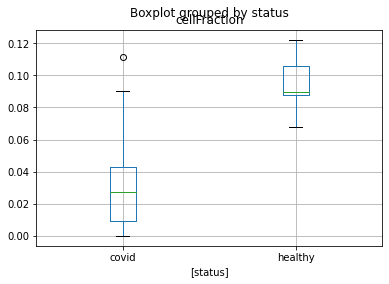

In [58]:
selected_cell = healty_vs_covid.index[np.nanargmin(healty_vs_covid.to_numpy())]
status_df = pd.DataFrame(metadata["status"])
status_df["cellFraction"] = music_frac[[selected_cell]]
status_df.boxplot(by="status")

(deconvolution-bulk-deconvolution-key-takeaway-3)=
(deconvolution-bulk-deconvolution-key-takeaway-4)=
## Limitations and traps

While single cell data is less prone to contain missing cell types, compared to pre-selected sorted cells, dealing with missing cell types is still considered a major challenge in the field of cell type deconvolution to this day {cite}`Cobos2020,Jin2021`. In addition, the number of cell types within the signature matrix has a major influence on deconvolution accuracy, as more cell types usually results in a less accurate deconvolution process {cite}`Newman2019`. 

While several deconvolution methods can correctly infer the proportion of major cellular components, their performance for rare or correlated components varies. To deal with the co-linearity between the predictors some methods perform feature selection prior deconvolution by selecting a subset of genes (called signature gene list) that minimizes the correlation between cell types.

## New directions

Other than the methods we described before, there are additional tools which can be utilize to either improve deconvolution or decovolve higher resolution states within cell types:

**AutoGeneS** {cite}`Aliee2021` proposes a multi-objective feature selection method that can be integrated into a deconvolution platform. AutoGeneS requires no prior knowledge about marker genes and selects genes by simultaneously optimizing multiple criteria: minimizing the correlation and maximizing the distance between cell types.
AutoGeneS can be applied to reference profiles from various sources like single-cell experiments or sorted
cell populations. 

**CPM** {cite}`Frishberg2019` is a cell-state deconvolution method which allows discovering compositional changes occurring within each cell type, based on the single cell cell space, often capturing transitions in cell compositions across continuous cellular trajectories.
By focusing on the variation within cell types, and less between cell types (as most deconvolution methods), CPM can discover changes in compositions of distinct subgroups of cells or continuous changes across specific cellular trajectories. 

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: bulk
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Hananeh Aliee
* Amit Frishberg